In [1]:
import pandas as pd
import numpy as np
from numpy import nan
from scipy import stats
from datetime import date, datetime
import investpy
from pandas_datareader import data as pdr
from pandas_profiling import ProfileReport

import os
import csv
import sys
import torch
import torch.nn as nn
import time
import random
import shap
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.cluster import MiniBatchKMeans
from scipy.cluster.vq import vq
from sklearn.manifold import TSNE
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier

In [2]:
device = torch.device("cpu")

class Autoencoder(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Autoencoder, self).__init__()
        seed = 123
        torch.manual_seed(seed)
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        np.random.seed(seed)
        random.seed(seed)
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.deterministic = True
        
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
        )
        self.decoder = nn.Sequential(
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, output_dim),
            nn.Sigmoid(),
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


class ConvAutoEncoder(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(ConvAutoEncoder, self).__init__()
        seed = 123
        torch.manual_seed(seed)
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        np.random.seed(seed)
        random.seed(seed)
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.deterministic = True

        # Encoder
        self.cnn_layer1 = nn.Sequential(
            nn.Conv1d(input_dim, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(2, 2))

        self.cnn_layer2 = nn.Sequential(
            nn.Conv1d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(2, 2))

        # Decoder
        self.tran_cnn_layer1 = nn.Sequential(
            nn.ConvTranspose1d(32, 16, kernel_size=2, stride=2, padding=0),
            nn.ReLU())

        self.tran_cnn_layer2 = nn.Sequential(
            nn.ConvTranspose1d(16, output_dim, kernel_size=2, stride=2, padding=0),
            nn.Sigmoid())

    def forward(self, x):
        # print(x.shape)
        output = self.cnn_layer1(x)
        # print(output.shape)
        output = self.cnn_layer2(output)
        # print(output.shape)
        output = self.tran_cnn_layer1(output)
        # print(output.shape)
        output = self.tran_cnn_layer2(output)
        # print(output.shape)

        return output


class k_clustering():
    def __init__(self, dataframe, dim):
        self.df = dataframe
        self.df_values = self.df.values
        self.data = torch.tensor(self.df_values, dtype=torch.float32)
        self.dim = dim

    def preprocess_with_autoencoder(self, t_sne_dim, decoder_dim=None):
        # autoencoder input dimension
        input_dim = self.data.size(1)

        # output dimension 설정
        if decoder_dim != None:
            output_dim = decoder_dim
        else:
            output_dim = self.data.size(1)

        # 모델 통과
        model = Autoencoder(input_dim, output_dim).to(device)
        output = model(self.data).to(device)
        print("autoencoder output shape:", output.shape)

        # tensor numpy로 변환
        output = output.detach().numpy()
        # print(output)

        # T-SNE로 차원 축소
        t_sne_model = TSNE(t_sne_dim)
        t_sne_output = t_sne_model.fit_transform(output)
        print("T-SNE output shape:", t_sne_output.shape)

        return t_sne_output

    def preprocess_with_conv_autoencoder(self, t_sne_dim, decoder_dim=None):
        # convolutional layer input을 위한 transpose
        transpose_input = torch.transpose(self.data, 1, 0)
        input_dim = transpose_input.size(0)

        # 추후 최적화 때 실험할 output dimension 설정
        if decoder_dim != None:
            output_dim = decoder_dim
        else:
            output_dim = transpose_input.size(0)

        # 모델 통과
        model = ConvAutoEncoder(input_dim, output_dim).to(device)
        decoded = model(transpose_input).to(device)
        transpose_output = torch.transpose(decoded, 1, 0)
        print("Conv Autoencoder output shape:", transpose_output.shape)

        # Numpy 변환
        transpose_output = transpose_output.detach().numpy()

        # output dimension for T-SNE
        t_sne_model = TSNE(t_sne_dim)
        t_sne_output = t_sne_model.fit_transform(transpose_output)
        print("T-SNE output shape:", t_sne_output.shape)

        return t_sne_output

    def k_means_clustering(self, num_cluster, autoencoder_type, title):
        clustering_input = None
        if str(autoencoder_type) == ("linear" or "Linear"):
            clustering_input = self.preprocess_with_autoencoder(2)
        elif str(autoencoder_type) == ("conv" or "Conv"):
            clustering_input = self.preprocess_with_conv_autoencoder(2)
        else:
            assert autoencoder_type == "linear" or autoencoder_type == "conv"

        print("Clustering input dimension:", clustering_input.shape)

        k_means = KMeans(init="k-means++", n_clusters=num_cluster, random_state = 1)
        k_means.fit(clustering_input)
        cluster = k_means.predict(clustering_input)
        labels = k_means.labels_
        centers = k_means.cluster_centers_

        # Medoid 찾기
        closest, distances = vq(centers, clustering_input)
        print("Closest Medoid Indexs are", closest)

        # 2차원인 경우 그래프 그리기
        if clustering_input.shape[1] == 2:
            fig = plt.figure(figsize=(6, 4))
            colors = plt.cm.Spectral(np.linspace(0, 1, len(set(labels))))
            graph = fig.add_subplot(1, 1, 1)

            for k, col, close_idx in zip(range(6), colors, closest):
                my_members = (labels == k)
                if my_members[close_idx] == True:
                    graph.plot(clustering_input[close_idx, 0], clustering_input[close_idx, 1], markerfacecolor=col,
                               marker='h', markeredgecolor='b', markersize=20)
                graph.plot(clustering_input[my_members, 0], clustering_input[my_members, 1], linestyle='None', mec='k',
                           mew=0.5, markerfacecolor=col, marker='o', markersize=5)
                # graph.plot(input_data[close_center, 0], input_data[close_center, 1], 'o', markerfacecolor=col, markeredgecolor='k', markersize=20)

            graph.set_title(title)
            graph.set_xticks(())
            graph.set_yticks(())
            plt.show()

        return labels, closest, k_means

    # 실루엣 지수로 최적화
    def optimize_clustering(self, autoencoder_type):
        clustering_input = None
        if str(autoencoder_type) == ("linear" or "Linear"):
            clustering_input = self.preprocess_with_autoencoder(2)
        elif str(autoencoder_type) == ("conv" or "Conv"):
            clustering_input = self.preprocess_with_conv_autoencoder(2)
        else:
            assert autoencoder_type == "linear" or autoencoder_type == "conv"

        print("Clustering input dimension:", clustering_input.shape)

        best_num_cluster = 0
        best_silhouette_score = -1
        k_range = range(2, 7)

        inertia_list = []

        for k in k_range:
            # k_means = MiniBatchKMeans(init="k-means++", n_clusters=k, n_init=5, random_state = 1, batch_size=5)
            k_means = KMeans(init="k-means++", n_clusters=k, random_state=1)
            k_means.fit(clustering_input)
            cluster = k_means.predict(clustering_input)

            # silhouette score calculation
            score = silhouette_score(clustering_input, cluster)
            print('k:', k, "silhouette score:", score)

            inertia = k_means.inertia_
            inertia_list.append(inertia)

            if score > best_silhouette_score:
                best_num_cluster = k
                best_silhouette_score = score

        print("Best number of clusters:", best_num_cluster, "Score:", best_silhouette_score)

        return best_num_cluster

## Sub Cluster Optimization

### Class 2 SubCluster

In [3]:
df = pd.read_csv('/home/work/data/FBA_Finals_cluster2.csv')
df = df.iloc[:,2:-2]
print(df)

      SEX_F  SEX_M  age_group  income_group  account_age  LIFESTAGE_1  \
0       0.0    1.0      0.625           0.0     0.196787          0.0   
1       0.0    1.0      0.000           0.0     0.061247          0.0   
2       1.0    0.0      0.375           0.0     0.041839          0.0   
3       1.0    0.0      1.000           0.0     0.974149          0.0   
4       1.0    0.0      0.375           0.0     0.171174          0.0   
...     ...    ...        ...           ...          ...          ...   
1832    1.0    0.0      0.125           0.0     0.061645          0.0   
1833    1.0    0.0      0.250           0.0     0.064827          0.0   
1834    1.0    0.0      0.250           0.0     0.067611          0.0   
1835    1.0    0.0      0.750           0.0     0.004454          0.0   
1836    0.0    1.0      0.125           0.0     0.046532          0.0   

      LIFESTAGE_2  LIFESTAGE_3  LIFESTAGE_4  LIFESTAGE_5  ...  \
0             0.0          0.0          0.0          0.0  

In [4]:
dims = [2]
for dim in dims:
    model = k_clustering(df, dim)
    optimal_num_cluster = model.optimize_clustering('conv')

Conv Autoencoder output shape: torch.Size([1836, 54])


The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.


T-SNE output shape: (1836, 2)
Clustering input dimension: (1836, 2)
k: 2 silhouette score: 0.4866117
k: 3 silhouette score: 0.5790989
k: 4 silhouette score: 0.7527745
k: 5 silhouette score: 0.6801591
k: 6 silhouette score: 0.5912187
Best number of clusters: 4 Score: 0.7527745


### Class 2 Optimal SubCluster

Conv Autoencoder output shape: torch.Size([1836, 54])


The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.


T-SNE output shape: (1836, 2)
Clustering input dimension: (1836, 2)
Closest Medoid Indexs are [1257 1175 1360 1702]


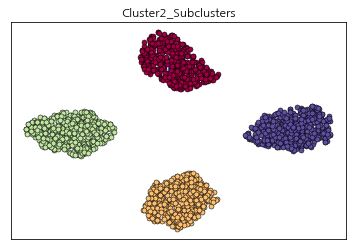

--- 6.486989736557007 seconds ---


In [4]:
start_time = time.time()

model = k_clustering(df, 2)
optimal_num_cluster = 4
title = 'Cluster2_Subclusters'
labels, medoids, k_means = model.k_means_clustering(optimal_num_cluster, "conv", title)

print("--- %s seconds ---" % (time.time() - start_time))

### Labeling Class 2 Subclusters

In [5]:
df = df.iloc[:-1]
df['Label'] = labels
account = pd.read_csv('/home/work/data/FBA_Finals_cluster2.csv')
account = account.iloc[:,1:2]
df.insert(loc=0, column='act_no', value=account[account.columns[0]])
print(df)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


        act_no  SEX_F  SEX_M  age_group  income_group  account_age  \
0     0.000300    0.0    1.0      0.625           0.0     0.196787   
1     0.000900    0.0    1.0      0.000           0.0     0.061247   
2     0.001300    1.0    0.0      0.375           0.0     0.041839   
3     0.001901    1.0    0.0      1.000           0.0     0.974149   
4     0.002401    1.0    0.0      0.375           0.0     0.171174   
...        ...    ...    ...        ...           ...          ...   
1831  0.995499    0.0    1.0      0.375           0.0     0.059577   
1832  0.996399    1.0    0.0      0.125           0.0     0.061645   
1833  0.996999    1.0    0.0      0.250           0.0     0.064827   
1834  0.997699    1.0    0.0      0.250           0.0     0.067611   
1835  0.998600    1.0    0.0      0.750           0.0     0.004454   

      LIFESTAGE_1  LIFESTAGE_2  LIFESTAGE_3  LIFESTAGE_4  ...  \
0             0.0          0.0          0.0          0.0  ...   
1             0.0          1.

### Save Class 2 Subclusters Labels

In [8]:
df.to_csv('/home/work/data/FBA_Finals_cluster2_after_labeling.csv')

### Class 2 Subclusters Shap Bar Plot

In [8]:
cluster_df = pd.read_csv('/home/work/data/FBA_Finals_cluster2_after_labeling.csv')
cluster_df = cluster_df.iloc[:, 2:-1]
print(cluster_df)

      SEX_F  SEX_M  age_group  income_group  account_age  LIFESTAGE_1  \
0       0.0    1.0      0.625           0.0     0.196787          0.0   
1       0.0    1.0      0.000           0.0     0.061247          0.0   
2       1.0    0.0      0.375           0.0     0.041839          0.0   
3       1.0    0.0      1.000           0.0     0.974149          0.0   
4       1.0    0.0      0.375           0.0     0.171174          0.0   
...     ...    ...        ...           ...          ...          ...   
1831    0.0    1.0      0.375           0.0     0.059577          0.0   
1832    1.0    0.0      0.125           0.0     0.061645          0.0   
1833    1.0    0.0      0.250           0.0     0.064827          0.0   
1834    1.0    0.0      0.250           0.0     0.067611          0.0   
1835    1.0    0.0      0.750           0.0     0.004454          0.0   

      LIFESTAGE_2  LIFESTAGE_3  LIFESTAGE_4  LIFESTAGE_5  ...  \
0             0.0          0.0          0.0          0.0  

In [9]:
start_time = time.time()

clf = RandomForestClassifier()
clf.fit(cluster_df,labels)
print("classifier done")
explainer = shap.TreeExplainer(clf)
print("Explainer defined")

shap_values = explainer.shap_values(cluster_df)
print(shap_values)
print("--- %s seconds ---" % (time.time() - start_time))

classifier done
Explainer defined
[array([[-7.37489727e-04,  4.61408003e-04, -5.62204766e-03, ...,
        -2.21349303e-04, -1.34092118e-03, -1.86474091e-02],
       [ 1.40711619e-02,  2.58692445e-02,  1.12255502e-02, ...,
         7.65709873e-04,  1.27136211e-03,  3.93439882e-03],
       [-1.08476634e-03, -1.27395784e-03, -9.20266007e-03, ...,
         1.43710161e-04,  1.27200230e-04, -8.22482193e-03],
       ...,
       [ 8.02816381e-03,  7.16797088e-05,  4.40385002e-02, ...,
         9.93066133e-04,  2.21197435e-03,  1.16496021e-02],
       [-2.26902824e-03, -7.69955941e-04, -3.70226121e-03, ...,
        -1.93066378e-04, -7.61260748e-04, -1.14458869e-02],
       [-7.81589307e-03, -3.43463065e-03, -6.48601678e-03, ...,
         7.40834908e-04, -6.85243260e-04, -7.25178637e-03]]), array([[-0.00089423, -0.00323136, -0.01268837, ..., -0.00081319,
        -0.00021841, -0.00402238],
       [-0.00421541, -0.00642415, -0.01292669, ...,  0.00049624,
         0.00031931,  0.00466017],
       

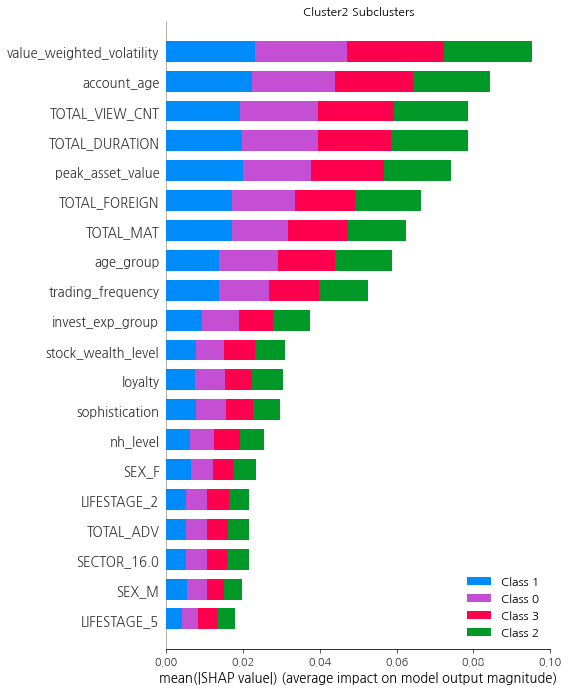

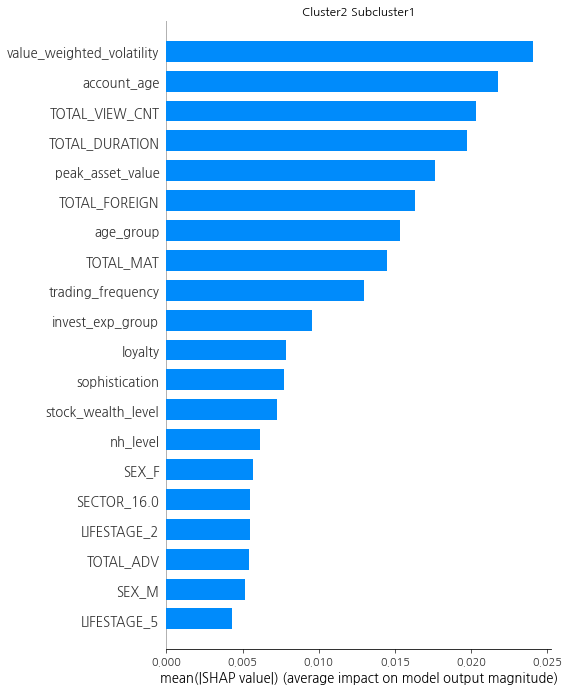

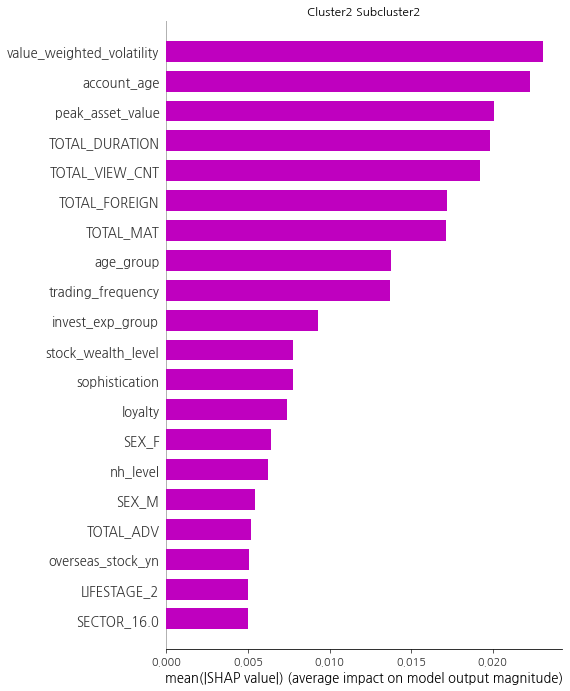

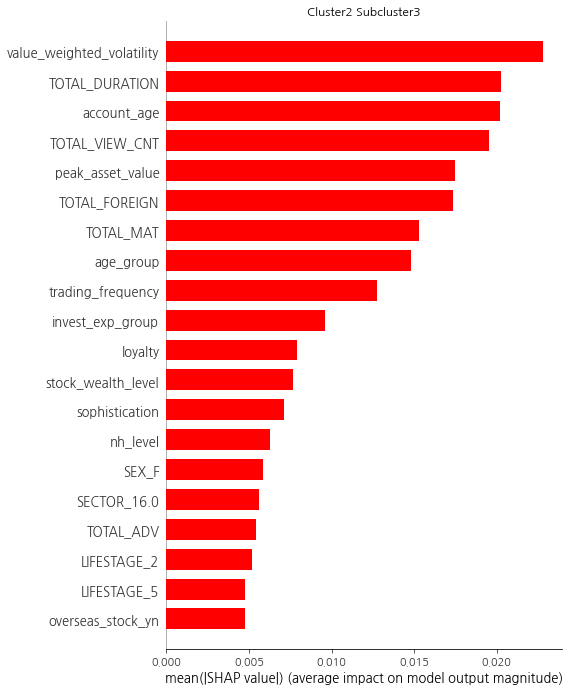

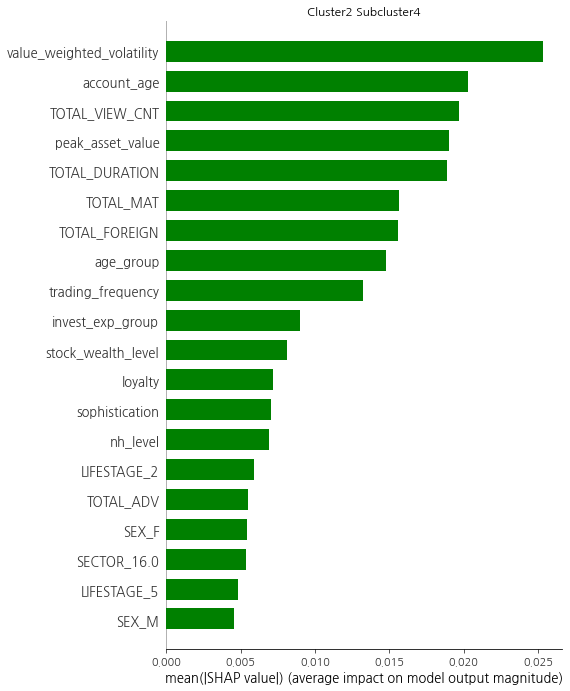

In [10]:
shap.summary_plot(shap_values, cluster_df, plot_type='bar', show = False)
plt.title('Cluster2 Subclusters')
plt.show()
shap.summary_plot(shap_values[0], cluster_df, plot_type='bar', show = False)
plt.title('Cluster2 Subcluster1')
plt.show()
shap.summary_plot(shap_values[1], cluster_df, plot_type='bar', show = False, color = 'm')
plt.title('Cluster2 Subcluster2')
plt.show()
shap.summary_plot(shap_values[2], cluster_df, plot_type='bar', show = False, color = 'r')
plt.title('Cluster2 Subcluster3')
plt.show()
shap.summary_plot(shap_values[3], cluster_df, plot_type='bar', show = False, color = 'g')
plt.title('Cluster2 Subcluster4')
plt.show()

### SubClusters CSV File created

In [6]:
cluster0 = []
cluster1 = []
cluster2 = []
cluster3 = []

center0 = []
center1 = []
center2 = []
center3 = []

for idx in range(len(df)):
    if df.values[idx][-1] == 0:
        cluster0.append(df.values[idx])
        
        if idx == medoids[0]:
            center0.append(0)
        else:
            center0.append(np.nan)        
        
    if df.values[idx][-1] == 1:
        cluster1.append(df.values[idx])
        
        if idx == medoids[1]:
            center1.append(1)
        else:
            center1.append(np.nan)        
        
    if df.values[idx][-1] == 2:
        cluster2.append(df.values[idx])
        
        if idx == medoids[2]:
            center2.append(2)
        else:
            center2.append(np.nan)        
        
    if df.values[idx][-1] == 3:
        cluster3.append(df.values[idx])

        if idx == medoids[3]:
            center3.append(3)
        else:
            center3.append(np.nan)


df0 = pd.DataFrame(cluster0)
df1 = pd.DataFrame(cluster1)
df2 = pd.DataFrame(cluster2)
df3 = pd.DataFrame(cluster3)


df0.columns = df.columns
df1.columns = df.columns
df2.columns = df.columns
df3.columns = df.columns


df0['Center'] = center0
df1['Center'] = center1
df2['Center'] = center2
df3['Center'] = center3

In [7]:
df0.to_csv('/home/work/data/FBA_Finals_cluster2_subcluster1.csv')
df1.to_csv('/home/work/data/FBA_Finals_cluster2_subcluster2.csv')
df2.to_csv('/home/work/data/FBA_Finals_cluster2_subcluster3.csv')
df3.to_csv('/home/work/data/FBA_Finals_cluster2_subcluster4.csv')

Summarize dataset:  98%|#########8| 354/361 [00:51<00:00,  9.21it/s, Missing diagram bar]                                         FixedFormatter should only be used together with FixedLocator
There was an attempt to generate the Count missing values diagrams, but this failed.
To hide this warning, disable the calculation
(using `df.profile_report(missing_diagrams={"Count": False}`)
If this is problematic for your use case, please report this as an issue:
https://github.com/ydataai/pandas-profiling/issues
(include the error message: 'The number of FixedLocator locations (7), usually from a call to set_ticks, does not match the number of ticklabels (57).')
Summarize dataset:  98%|#########8| 354/361 [00:50<00:00,  9.81it/s, Missing diagram bar]                                         FixedFormatter should only be used together with FixedLocator
There was an attempt to generate the Count missing values diagrams, but this failed.
To hide this warning, disable the calculation
(using `df.pro

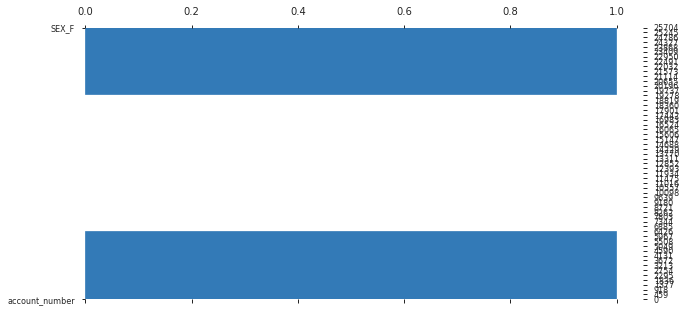

In [13]:
df_c1 = pd.read_csv('/home/work/data/FBA_Finals_cluster2_subcluster1.csv', index_col = 0)
df_c2 = pd.read_csv('/home/work/data/FBA_Finals_cluster2_subcluster2.csv', index_col = 0)
df_c3 = pd.read_csv('/home/work/data/FBA_Finals_cluster2_subcluster3.csv', index_col = 0)
df_c4 = pd.read_csv('/home/work/data/FBA_Finals_cluster2_subcluster4.csv', index_col = 0)
profile_c1 = ProfileReport(df_c1, title="Report")
profile_c2 = ProfileReport(df_c2, title="Report")
profile_c3 = ProfileReport(df_c3, title="Report")
profile_c4 = ProfileReport(df_c4, title="Report")
profile_c1.to_file("/home/work/data/FBA_Finals_cluster2_subcluster1.html")
profile_c2.to_file("/home/work/data/FBA_Finals_cluster2_subcluster2.html")
profile_c3.to_file("/home/work/data/FBA_Finals_cluster2_subcluster3.html")
profile_c4.to_file("/home/work/data/FBA_Finals_cluster2_subcluster4.html")